# Import

In [1]:
import multiprocessing
from tqdm import tqdm
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries
import os
import numpy as np
import pandas as pd
import h5py as h5
from os import listdir
import torch
from gwpy.signal import filter_design
from qtransform_delta import *

In [2]:
import torch
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'
print(f'{device=}')

NVIDIA A100-PCIE-40GB
device='cuda'


In [3]:
import importlib
import sys
from qtransform_gpu import *

<module 'qtransform_delta' from '/home/jovyan/qtransform_delta.py'>

In [4]:
from Annalisa_gpu import *

NVIDIA A100-PCIE-40GB
Running on device: device='cuda'
NVIDIA A100-PCIE-40GB
Running on device: device='cuda'


<module 'Preprocess' from '/home/jovyan/Preprocess.py'>

In [5]:
from ml4gw.transforms import SpectralDensity,Whiten

# **Create Dataset**

## Load Data

**Load torch tensor**

In [6]:
#file_path='/data/notebooks_intertwin/Merged_Dataset_Hraw&Hrec.pt'
file_path='/data/notebooks_intertwin/Merged_Dataset_Hraw&Hrec.pt'
#df=pd.read_pickle(file_path)
data = torch.load(file_path)

## Create  Synthetic Dataset

In this section, we create a synthetic dataset to train generative models with.

### TimeSeries Dataset

In [6]:
def generate_dataset_aux_channels_tensor(rows, columns, duration=10, sample_rate=500, num_waves_range=(10, 15), noise_amplitude=0.1):
    """
    Generate a PyTorch tensor with randomly generated smooth sine wave time series with added smooth random noise.

    Parameters:
        - rows (int): Number of rows in the tensor.
        - columns (int): Number of columns in the tensor.
        - duration (float): Duration of the time series data in seconds (default is 6 seconds).
        - sample_rate (int): Sampling rate of the time series data in samples per second (default is 500 samples per second).
        - num_waves_range (tuple): Range for the random number of sine waves to be generated for each time series.
                                    Format: (min_num_waves, max_num_waves) (default is (10, 15)).
        - noise_amplitude (float): Amplitude of the smooth random noise added to the time series data (default is 0.1).

    Returns:
        - Tensor: PyTorch tensor containing the generated time series data.  Shape will be (rows, columns, time_samples)
    """
    time_samples = int(duration * sample_rate)  # Calculate total time samples
    times = torch.linspace(0, duration, time_samples)

    # Initialize the tensor
    tensor_data = torch.zeros((rows, columns, time_samples))

    for row in range(rows):
        for col in range(columns):
            wave_data = torch.zeros(time_samples)
            num_waves = np.random.randint(*num_waves_range)  # Use numpy for random int

            for _ in range(num_waves):
                amplitude = np.random.uniform(0.5, 2.0)
                frequency = np.random.uniform(0.5, 5.0)
                phase = np.random.uniform(0, 2 * np.pi)

                # Convert numpy values to tensors for calculations
                amplitude = torch.tensor(amplitude, dtype=torch.float32)
                frequency = torch.tensor(frequency, dtype=torch.float32)
                phase = torch.tensor(phase, dtype=torch.float32)

                wave_data += amplitude * torch.sin(2 * np.pi * frequency * times + phase)  # Use torch.sin

            smooth_noise = torch.normal(0, noise_amplitude, (time_samples,))
            wave_data += smooth_noise

            tensor_data[row, col, :] = wave_data  # Assign directly to the tensor

    return tensor_data

In [7]:
def generate_dataset_main_channel_tensor(input_tensor, weights=None, noise_amplitude=0.1):
    """
    Generate a tensor where each row of a single column is a weighted linear combination of the entries
    in the corresponding row in the input tensor plus random noise.

    Parameters:
        - input_tensor (Tensor): Input tensor generated by generate_dataset_aux_channels_tensor. Shape (rows, columns, time_samples)
        - weights (Tensor): Optional weights for each column. If None, random weights are generated (default is None). Shape (columns,)
        - noise_amplitude (float): Amplitude of the random noise added to the linear combination (default is 0.1).

    Returns:
        - Tensor: PyTorch tensor containing the generated linear combination data. Shape (rows, time_samples)
    """

    rows, columns, time_samples = input_tensor.shape

    # Generate random weights if not provided (as a tensor)
    if weights is None:
        weights = torch.rand(columns) + 0.5  # Random weights between 0.5 and 1.5
    elif not isinstance(weights, torch.Tensor):
        weights = torch.tensor(weights, dtype=torch.float32) # Ensure weights are a tensor

    # Initialize the output tensor
    output_tensor = torch.zeros((rows, time_samples))

    for row in range(rows):
        # Compute the weighted linear combination for each time sample in the row
        linear_combination = torch.sum(input_tensor[row, :, :] * weights.unsqueeze(1), dim=0) # Broadcasting weights across time samples

        # Add random noise to the linear combination
        noise = torch.normal(0, noise_amplitude, (time_samples,))
        linear_combination += noise

        output_tensor[row, :] = linear_combination

    return output_tensor

In [8]:
aux_ts=generate_dataset_aux_channels_tensor(1000, 3, duration=6, sample_rate=4096, num_waves_range=(20, 25), noise_amplitude=0.6)

In [11]:
strain_ts=generate_dataset_main_channel_tensor(aux_ts, weights=None, noise_amplitude=0.1).unsqueeze(1)

In [ ]:
data = torch.cat((strain_ts, aux_ts), dim=1)

In [ ]:
pat='path.pt'
torch.save(data,path)

## Preprocess

In [7]:
data.shape

torch.Size([8740, 26, 24576])

In [8]:
column_list=['V1:Hrec_hoft_raw_20000Hz', 'V1:LSC_DARM_NOISE', 'V1:LSC_PRCL',
       'V1:LSC_DARM_CORR', 'V1:LSC_PRCL_CORR', 'V1:LSC_MICH',
       'V1:LSC_PRCL_ERR_x', 'V1:LSC_DARM', 'V1:LSC_MICH_CORR',
       'V1:Hrec_hoft_16384Hz', 'V1:ENV_METEO_WIND_DIR',
       'V1:ENV_METEO_WIND_SPD', 'V1:ENV_NEB_SEIS_N', 'V1:ENV_NEB_SEIS_V',
       'V1:ENV_NEB_SEIS_W', 'V1:INJ_IMC_TRA_DC', 'V1:LSC_DARM_ERR',
       'V1:LSC_MICH_ERR', 'V1:LSC_NE_CORR', 'V1:LSC_PRCL_ERR_y',
       'V1:LSC_PR_CORR', 'V1:Sa_NE_F0_LVDT_V_500Hz', 'V1:Sa_NE_F0_TY_500Hz',
       'V1:Sa_NE_F0_X_500Hz', 'V1:Sa_NE_F0_Z_500Hz', 'V1:Sc_MC_MIR_Z_CORR']

In [9]:
batch_size = 5

In [10]:
#indices_to_select=[0, 2, 3, 4, 6, 7, 8, 16, 17, 19, 20]
#indices_to_select=torch.tensor([0, 2, 4,5, 6,8, 17, 19, 20])
path='xxx.pt'
indices_to_select=torch.load(path)

In [11]:
dataloader = DataLoader(
    data[:,indices_to_select,:],
    batch_size=batch_size,
    shuffle=False,
)

In [27]:
qtransform=QT_dataset(24576,4096,device=device,whiten=False,num_t_bins=64*6,num_f_bins=64).to(device)

self.whiten=False
self.duration=6.0


In [28]:
torch.cuda.empty_cache()

In [ ]:
qtransform_list=[]
global_s=time.time()
for batch in dataloader:
    storch=time.time()
    transformed= qtransform(batch.to(device=device)).detach().cpu() #torch.Tensor(event.value).to(device)
    #print(f'{transformed.shape=}')
    etorch=time.time()
    #print(f'Torch transform time: {etorch-storch}s')
    qtransform_list.append(transformed[:,:,:,128:-128])
    torch.cuda.empty_cache()
global_e=time.time()
print(f'TOTAL TIME: {global_e-global_s}s')

In [30]:
# Stack along a new dimension (dim=2 to add an extra dimension for tensor list)
stacked_tensor_2d = torch.cat(qtransform_list, dim=0).detach().cpu()

In [31]:
stacked_tensor_2d.shape

torch.Size([8740, 9, 128, 512])

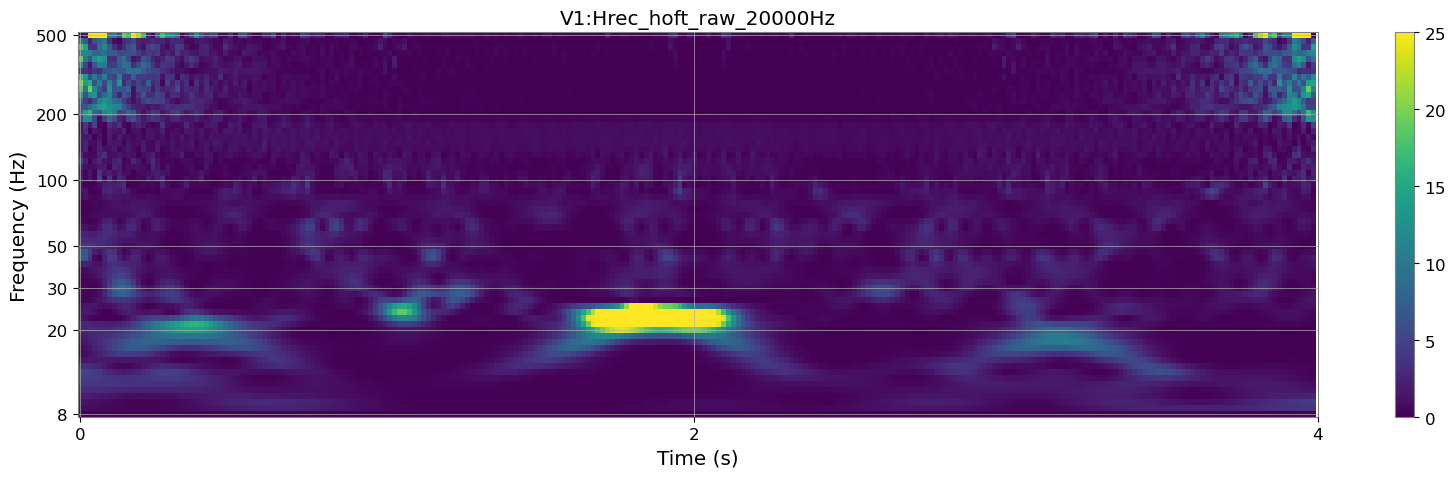

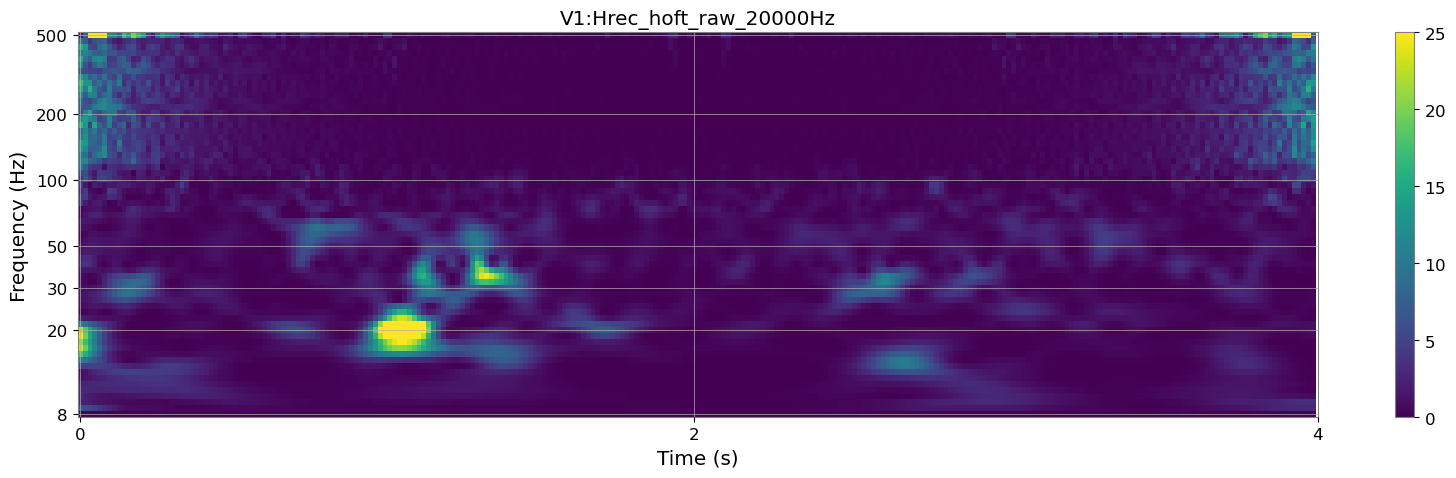

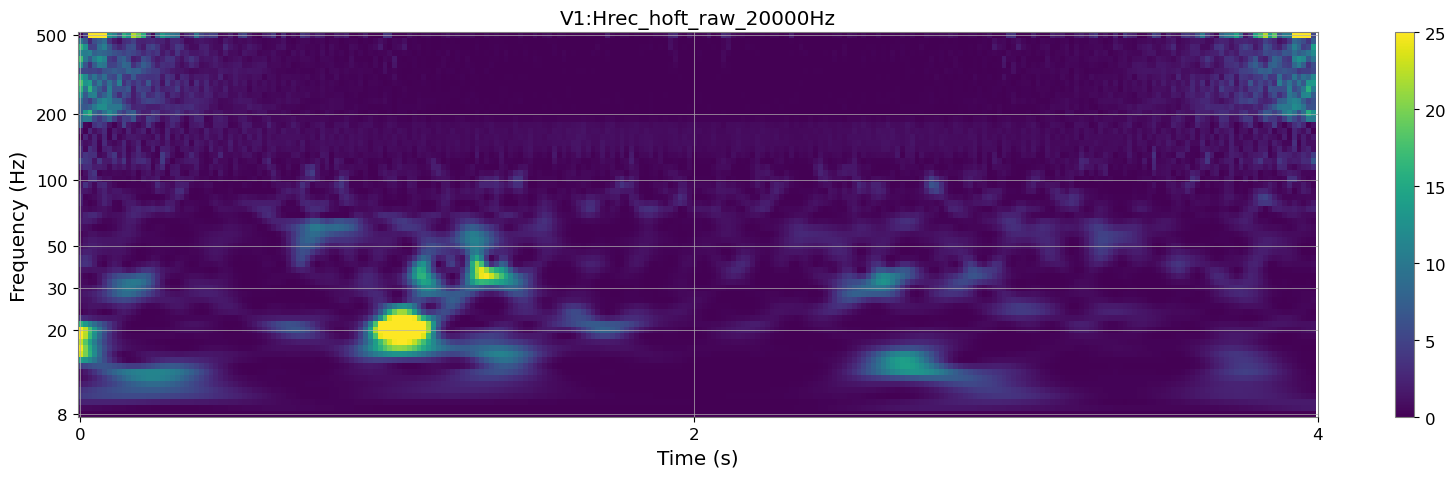

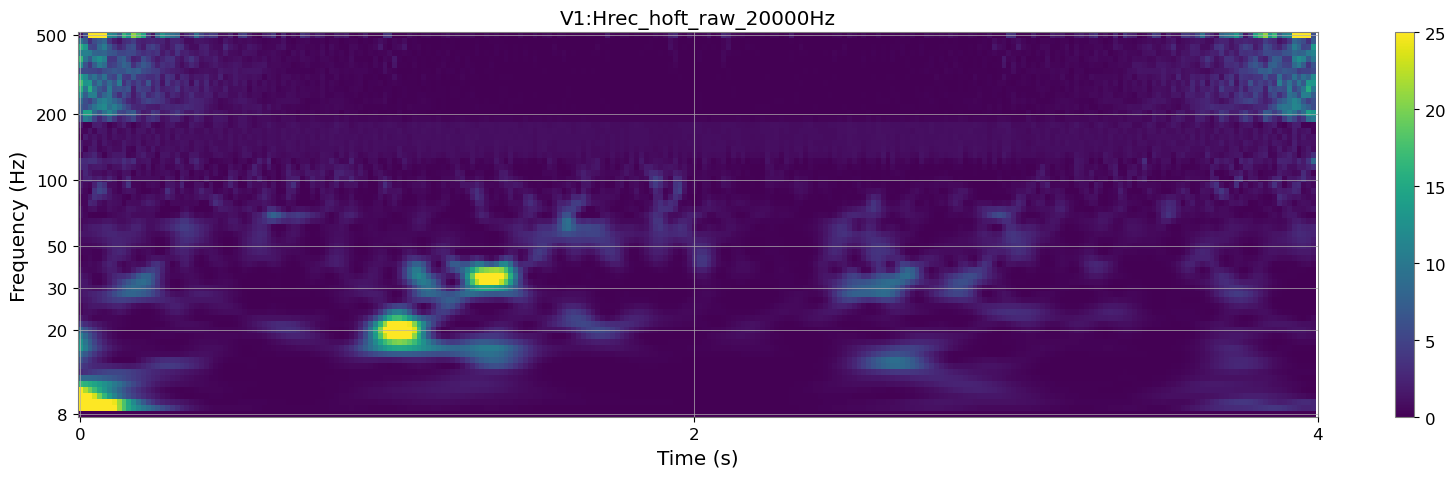

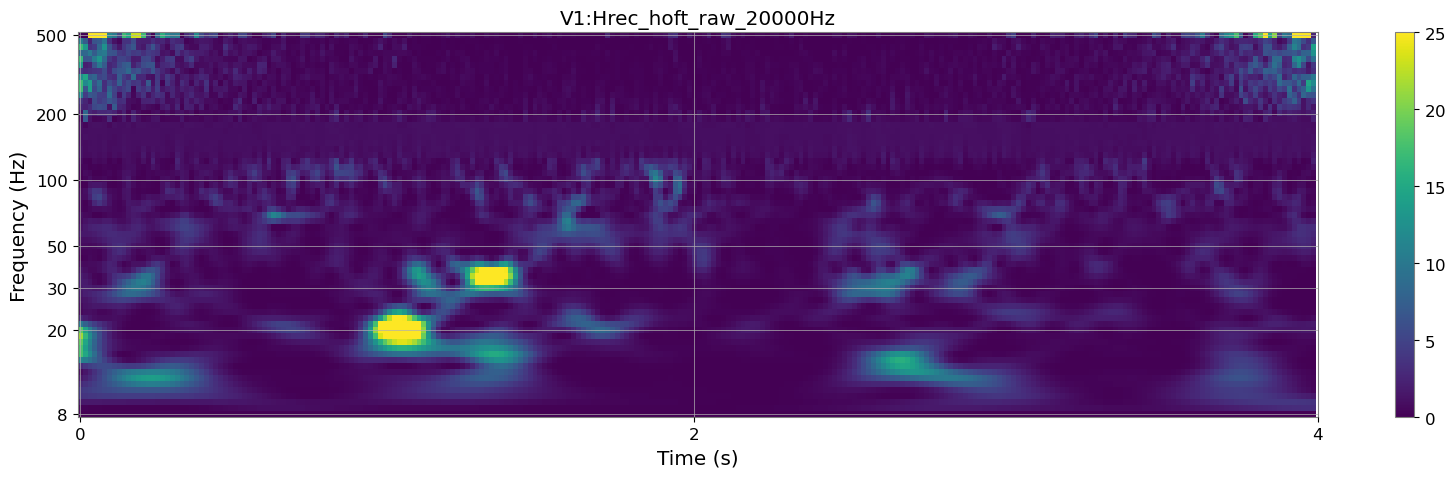

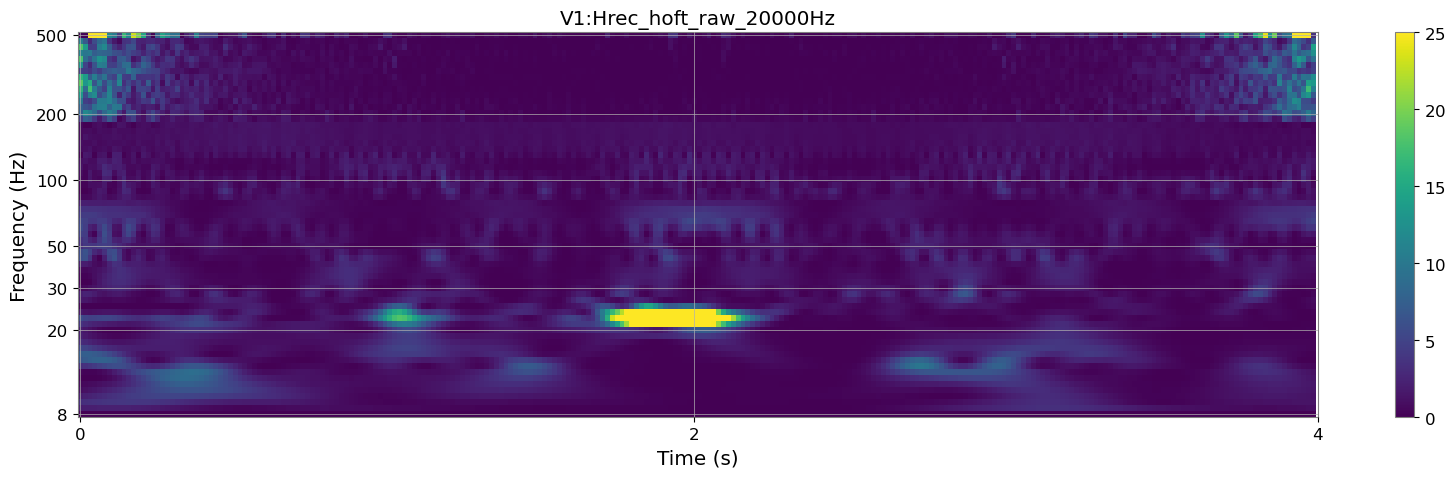

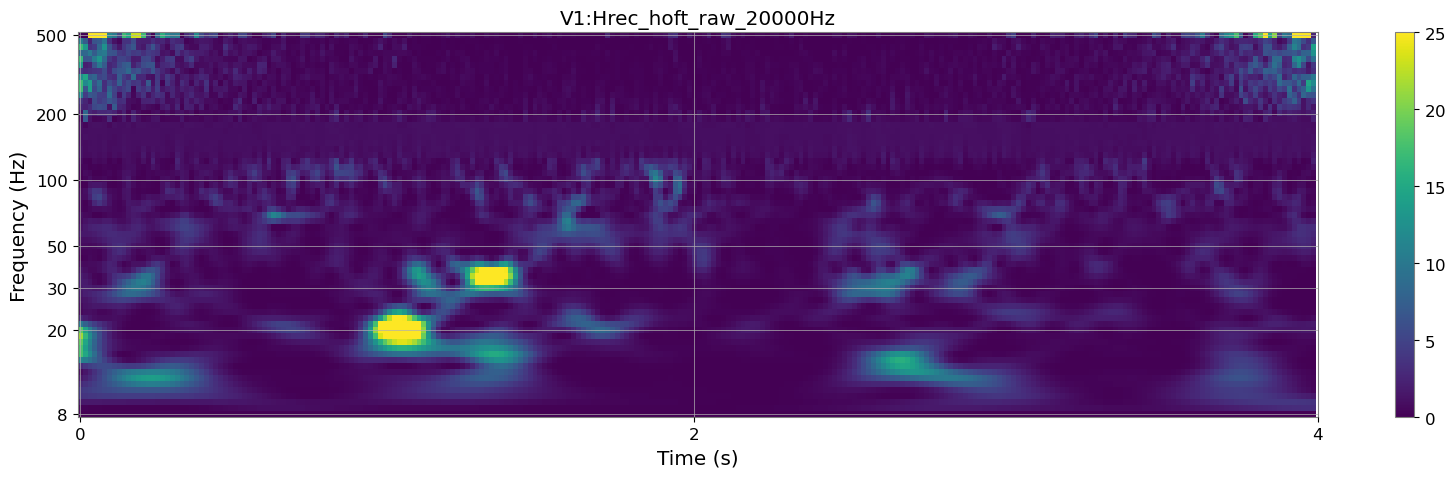

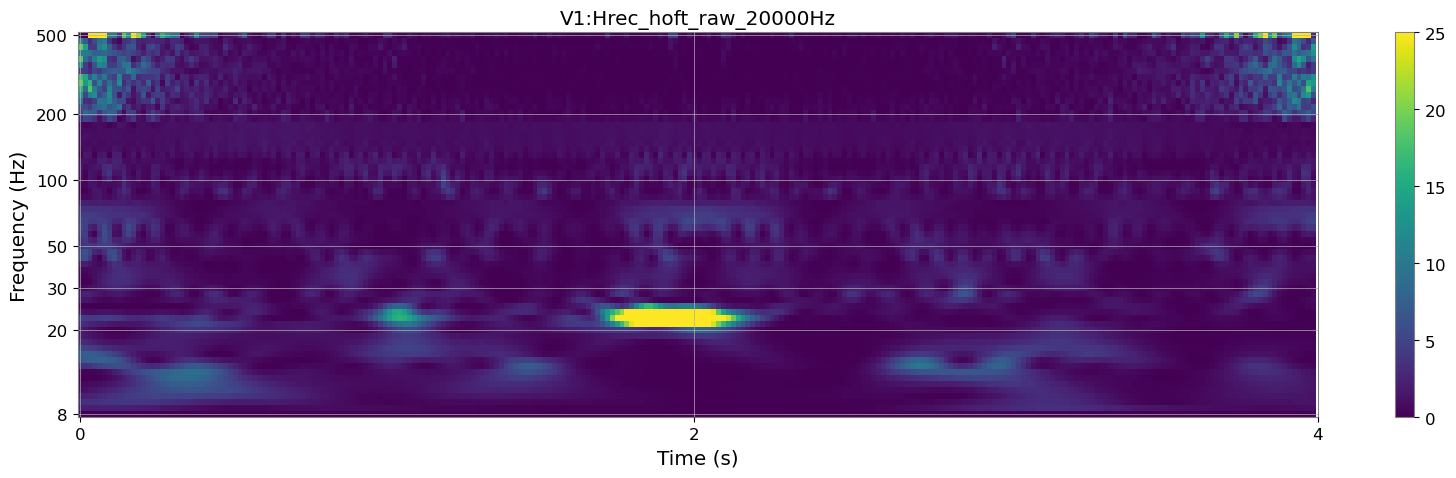

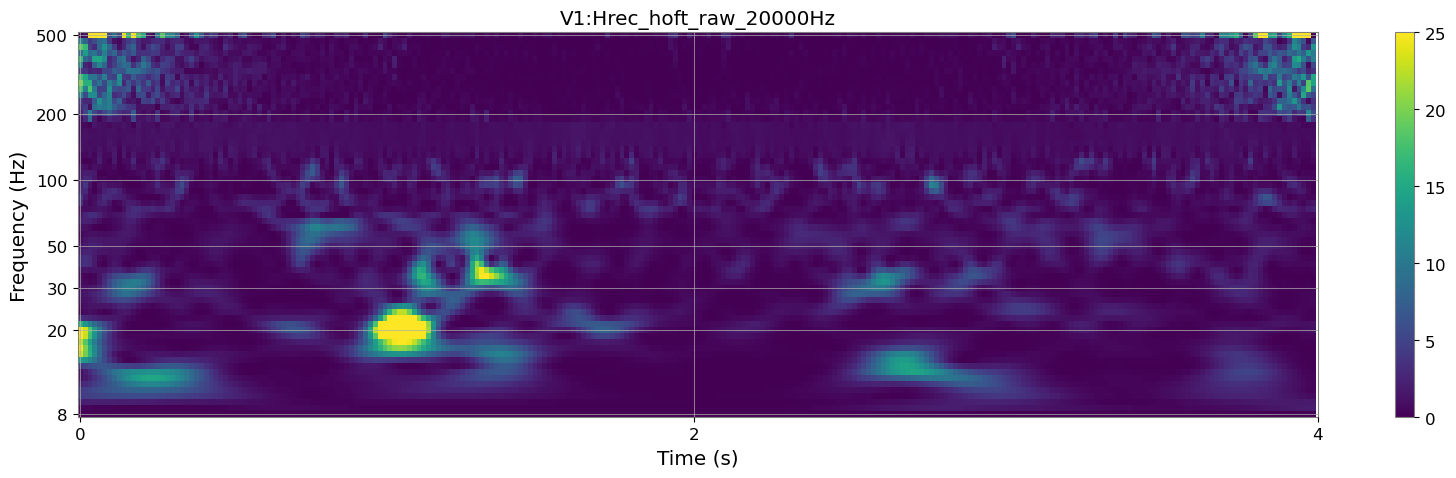

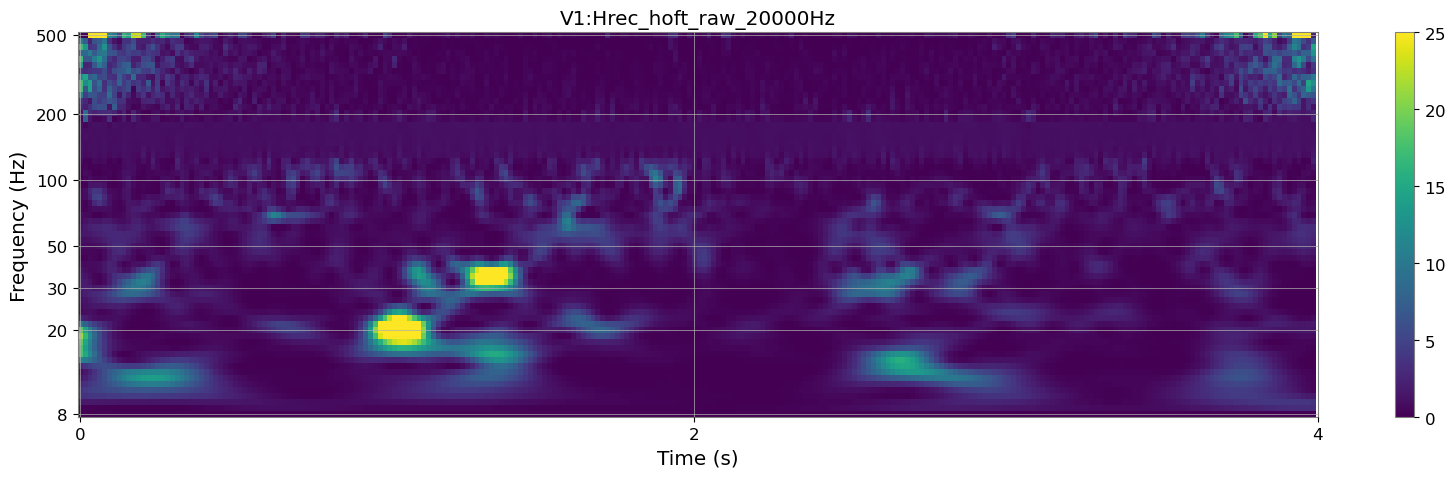

In [21]:
channel_idx = 0
f_range = (8, 500)
desired_ticks = [8, 20, 30, 50, 100, 200, 500]
log_base = 10  # Or np.e for natural log

for i in range(10):
    fig, axes = plt.subplots(1, 1, figsize=(20, 5))
    qplt_strain = torch.flipud(stacked_tensor_2d[channel_idx, i, :, :].detach().cpu())
    im = axes.imshow(qplt_strain, aspect='auto', vmin=0, vmax=25)
    axes.set_title(column_list[channel_idx])
    axes.set_xlabel('Time (s)')
    axes.set_ylabel('Frequency (Hz)')

    new_height = stacked_tensor_2d.shape[2]

    # 1. Log-transform the frequency range and desired ticks
    log_f_range = (np.log(f_range[0]) / np.log(log_base), np.log(f_range[1]) / np.log(log_base))
    log_desired_ticks = np.log(desired_ticks) / np.log(log_base)

    # 2. Map the LOG-TRANSFORMED TICKS to pixel values (REVERSED PIXEL RANGE)
    y_ticks_pixel = np.interp(log_desired_ticks, log_f_range, [new_height - 1, 0])

    y_ticks_pixel = [int(p) for p in y_ticks_pixel]
    y_ticks_pixel = np.clip(y_ticks_pixel, 0, new_height - 1)  # Keep in bounds

    y_ticks_pixel, unique_indices = np.unique(y_ticks_pixel, return_index=True)
    desired_ticks = np.array(desired_ticks)[unique_indices].tolist()

    axes.grid(True, axis='y', which='both')
    axes.set_yticks(y_ticks_pixel)
    axes.set_yticklabels(desired_ticks)
    axes.set_xticks([0,127,256])
    axes.set_xticklabels([0,2,4])

    fig.colorbar(im, ax=axes)
    plt.show()

In [22]:
del qtransform_list

In [32]:
out_dir='/home/jovyan/Qtransform Dataset'
save_name='QT_Hraw_Hrec_q_12_4_s_128x512_no_whiten_8-500Hz_logf_9channels'
torch.save(stacked_tensor_2d, f'{out_dir}/{save_name}.pt')

In [ ]:
duration=6.0
sr=500.0

In [ ]:
Ts_torch=Ts_torch[:,:,int((Ts_torch.shape[-1]-duration*sr)/2):int((Ts_torch.shape[-1]+duration*sr)/2)]

In [ ]:
Ts_torch.shape

Initialise torch Qtransform

**Now you have to eliminate entries that contain nans and replace them with empty tiles**

In [ ]:
qrange = [8,16,32]#16]#,32] #5.65685424949238 #12
num_t_bins=1000
fres = 0.5
frange=(5,50)
num_f_bins = int((frange[1] - frange[0]) / fres)
logf=False

In [ ]:
transformed_list=[]
for q in qrange:
    sinit=time.time()
    qtransform = SingleQTransform(sample_rate=sample_rate, duration=duration, q=q, frange=frange,spectrogram_shape=(num_t_bins,num_f_bins),logf=logf,qtiles_mode=True).to(device)
    einit=time.time()
    print(f'Initialisation time: {einit-sinit}s')
    storch=time.time()
    transformed= qtransform(Ts_torch,spectrogram_shape=(num_f_bins,num_t_bins)) #torch.Tensor(event.value).to(device)
    transformed_list.append(transformed)
    etorch=time.time()
    print(f'Torch transform time: {etorch-storch}s')

In [ ]:
Q_max_tiles_length=[]
for i,transformed in enumerate(transformed_list):
    print('----------------------------------')
    print(f'Q={2**(i+1)}')
    total_length=0
    for i in range(len(transformed)):
        print(transformed[i].shape)
        total_length+=transformed[i].shape[-1]
    Q_max_tiles_length.append(total_length)
    print(f'{total_length=}')

In [ ]:
max_length=max(Q_max_tiles_length)
max_length

In [ ]:
Q_unpadded_tensors=[torch.cat(transformed,dim=-1).detach().cpu() for transformed in transformed_list]

In [ ]:
padded_tensors=[]
for tensor in Q_unpadded_tensors:
    # Calculate the number of zeros needed to pad to 1024 along the last dimension
    padding = max_length - tensor.size(-1)
    
    # Apply padding (pad last dimension: (left_pad, right_pad) -> (0, padding))
    padded_tensor = F.pad(tensor, (0, padding))
    
    # Add the padded tensor to the list
    padded_tensors.append(padded_tensor)

# Stack along a new dimension (dim=2 to add an extra dimension for tensor list)
Q_padded_tensor = torch.stack(padded_tensors, dim=-1)

# Check the shape of the new tensor
print(Q_padded_tensor.shape)

In [ ]:
save_name='Qtile_1s_sr_200Hz_multiq_channels_15_1D'
ss=time.time()
torch.save(Q_padded_tensor, f'{out_dir}/{save_name}.pt') 
ee=time.time()
print(f'took {ee-ss}s')